# Model 1: Linear Pricing

This is the simplest model. It increases the price of a parking lot based on its occupancy level using a linear formula:

`Price = Base + α × (Occupancy / Capacity)`

Key Points:
- Base Price = $10  
- α (Alpha) is a scaling factor  
- Prices are capped between $5 and $20  
- Smooth price increase as more vehicles park

In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("dataset.csv")

# Let's preview the first few rows
df.head()


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [2]:
def linear_pricing_model(df, alpha=1.0, base_price=10.0):
    df = df.copy()
    df['Price'] = base_price

    for lot_id in df['ID'].unique():
        lot_df = df[df['ID'] == lot_id]
        previous_price = base_price

        for idx in lot_df.index:
            occupancy = df.loc[idx, 'Occupancy']
            capacity = df.loc[idx, 'Capacity']

            if capacity == 0:
                continue

            price_change = alpha * (occupancy / capacity)
            new_price = previous_price + price_change
            new_price = min(max(new_price, 5), 20)

            df.loc[idx, 'Price'] = round(new_price, 2)
            previous_price = new_price

    return df


In [3]:
df_model1 = linear_pricing_model(df)
df_model1[['ID', 'Occupancy', 'Capacity', 'Price']].head()


,ID,Occupancy,Capacity,Price
0,0,61,577,10.11
1,1,64,577,10.11
2,2,80,577,10.14
3,3,107,577,10.19
4,4,150,577,10.26


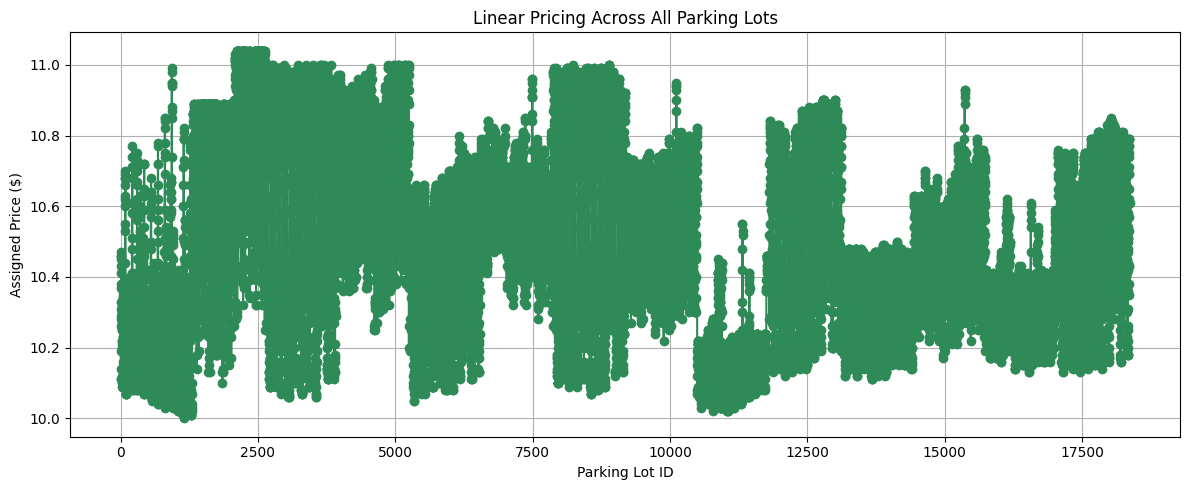

In [5]:
import matplotlib.pyplot as plt

# Sort by ID for a clean line
df_sorted = df_model1.sort_values(by='ID')

plt.figure(figsize=(12, 5))
plt.plot(df_sorted['ID'], df_sorted['Price'], marker='o', linestyle='-', color='seagreen')
plt.title("Linear Pricing Across All Parking Lots")
plt.xlabel("Parking Lot ID")
plt.ylabel("Assigned Price ($)")
plt.grid(True)
plt.tight_layout()
plt.savefig("model1_final_plot.png")  # Save for README
plt.show()

# Model 2: Demand-Based Pricing

**Demand** = α * (Occupancy / Capacity)
       + β * QueueLength
       - γ * Traffic
       + δ * IsSpecialDay
       + ε * VehicleTypeWeight

**Final Price** = Base × (1 + λ × Normalized Demand)

Capped between 0.5x and 2x base


In [9]:
def demand_based_pricing_model(df, base_price=10.0):
    df = df.copy()

    # Drop rows where Capacity is 0 to avoid division errors
    df = df[df['Capacity'] > 0].copy()

    # VEHICLE TYPE WEIGHTS
    vehicle_weights = {
        'bike': 0.2,
        'car': 0.5,
        'truck': 0.8
    }

    # Convert vehicle type to numeric weights
    df['VehicleWeight'] = df['VehicleType'].str.lower().map(vehicle_weights).fillna(0.5)

    # Ensure all columns are numeric where needed
    df['Occupancy'] = pd.to_numeric(df['Occupancy'], errors='coerce')
    df['Capacity'] = pd.to_numeric(df['Capacity'], errors='coerce')
    df['QueueLength'] = pd.to_numeric(df['QueueLength'], errors='coerce')
    df['TrafficConditionNearby'] = pd.to_numeric(df['TrafficConditionNearby'], errors='coerce')
    df['IsSpecialDay'] = pd.to_numeric(df['IsSpecialDay'], errors='coerce')

    # Feature Engineering
    df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
    df['NormalizedQueue'] = (df['QueueLength'] - df['QueueLength'].min()) / (df['QueueLength'].max() - df['QueueLength'].min())
    df['NormalizedTraffic'] = (df['TrafficConditionNearby'] - df['TrafficConditionNearby'].min()) / (df['TrafficConditionNearby'].max() - df['TrafficConditionNearby'].min())

    # Fill missing normalized values
    df[['OccupancyRate', 'NormalizedQueue', 'NormalizedTraffic']] = df[['OccupancyRate', 'NormalizedQueue', 'NormalizedTraffic']].fillna(0)

    # DEMAND SCORE (tunable weights)
    alpha = 0.5
    beta = 0.3
    gamma = 0.4
    delta = 0.6
    epsilon = 0.3

    df['DemandScore'] = (
        alpha * df['OccupancyRate'] +
        beta * df['NormalizedQueue'] -
        gamma * df['NormalizedTraffic'] +
        delta * df['IsSpecialDay'] +
        epsilon * df['VehicleWeight']
    )

    # Normalize DemandScore to 0–1
    min_d, max_d = df['DemandScore'].min(), df['DemandScore'].max()
    df['NormalizedDemand'] = (df['DemandScore'] - min_d) / (max_d - min_d)

    # Final Pricing Formula
    df['Price'] = base_price * (1 + 0.8 * df['NormalizedDemand'])
    df['Price'] = df['Price'].clip(lower=base_price * 0.5, upper=base_price * 2.0)
    df['Price'] = df['Price'].round(2)

    # Print check (optional)
    print("Missing values per column:")
    print(df[['OccupancyRate', 'NormalizedQueue', 'NormalizedTraffic', 'DemandScore', 'NormalizedDemand', 'Price']].isna().sum())

    return df


In [10]:
df_model2 = demand_based_pricing_model(df)
df_model2[['ID', 'Occupancy', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType', 'Price']].head()


Missing values per column:
OccupancyRate        0
NormalizedQueue      0
NormalizedTraffic    0
DemandScore          0
NormalizedDemand     0
Price                0
dtype: int64


,ID,Occupancy,QueueLength,TrafficConditionNearby,IsSpecialDay,VehicleType,Price
0,0,61,1,NaN,0,car,10.82
1,1,64,1,NaN,0,car,10.84
2,2,80,2,NaN,0,car,11.02
3,3,107,2,NaN,0,car,11.14
4,4,150,2,NaN,0,bike,10.86


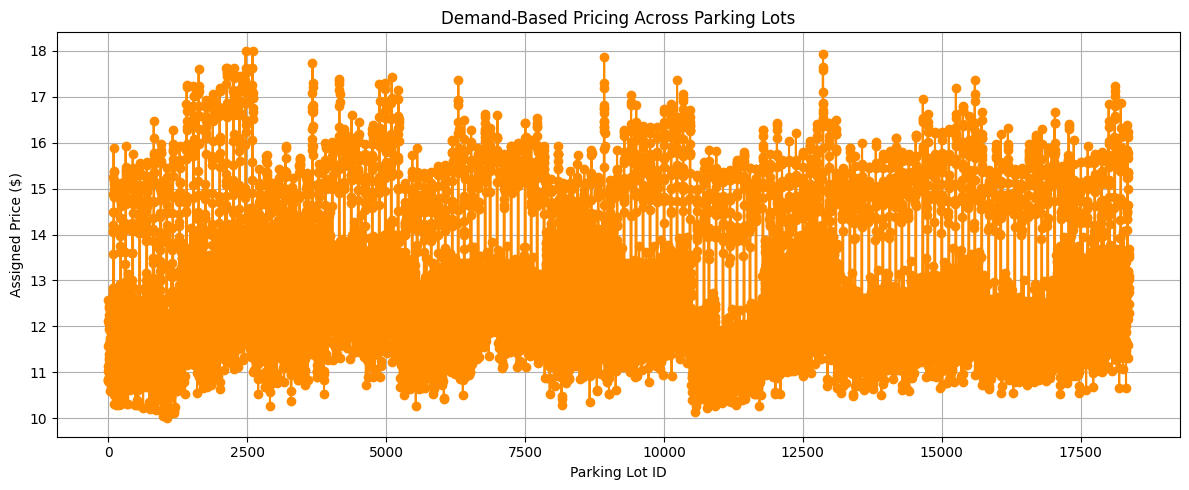

In [11]:
import matplotlib.pyplot as plt

df_sorted2 = df_model2.sort_values(by='ID')

plt.figure(figsize=(12, 5))
plt.plot(df_sorted2['ID'], df_sorted2['Price'], marker='o', linestyle='-', color='darkorange')
plt.title("Demand-Based Pricing Across Parking Lots")
plt.xlabel("Parking Lot ID")
plt.ylabel("Assigned Price ($)")
plt.grid(True)
plt.tight_layout()
plt.savefig("model2_demand_plot.png")  # Save for README
plt.show()

# Model 3: Competitive Pricing Based on Nearby Lots

This model adjusts a parking lot’s price based on nearby competitors using latitude and longitude.

Key Logic:
- If nearby lots are cheaper → reduce your price slightly  
- If nearby lots are costlier → increase your price  
- If no competitors nearby → add a small bonus

Distance between lots is calculated using the Haversine formula.
Final prices are adjusted while staying between $5 and $20.


In [12]:
from math import radians, cos, sin, asin, sqrt

# Haversine formula to calculate distance between 2 lat/lon points
def haversine(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

In [13]:
def apply_competitive_adjustment(df_model2, distance_threshold_km=1.0):
    df = df_model2.copy()
    adjusted_prices = []

    for i, row in df.iterrows():
        lat1 = row['Latitude']
        lon1 = row['Longitude']
        base_price = row['Price']

        # Find all nearby lots
        nearby_lots = df[df.index != i].copy()
        nearby_lots['Distance'] = nearby_lots.apply(
            lambda x: haversine(lat1, lon1, x['Latitude'], x['Longitude']),
            axis=1
        )

        close_competitors = nearby_lots[nearby_lots['Distance'] <= distance_threshold_km]

        # Adjust price based on competitor context
        if not close_competitors.empty:
            avg_competitor_price = close_competitors['Price'].mean()

            if base_price > avg_competitor_price + 2:
                # Your price is too high → reduce slightly
                new_price = base_price - 1
            elif base_price < avg_competitor_price - 2:
                # You’re underpriced → increase slightly
                new_price = base_price + 1
            else:
                # Keep it close
                new_price = base_price
        else:
            # No nearby competitors → slight boost allowed
            new_price = base_price + 0.5

        # Clip price to safe bounds
        new_price = max(5, min(20, round(new_price, 2)))
        adjusted_prices.append(new_price)

    df['Price_Competitive'] = adjusted_prices
    return df


In [14]:
# Competitive Pricing Model (Model 3)
# Using a smaller sample to reduce compute time for demonstration

df_sample = df_model2.head(500)
df_model3_sample = apply_competitive_adjustment(df_sample)

df_model3_sample[['ID', 'Latitude', 'Longitude', 'Price', 'Price_Competitive']].head()


,ID,Latitude,Longitude,Price,Price_Competitive
0,0,26.144536,91.736172,10.82,10.82
1,1,26.144536,91.736172,10.84,10.84
2,2,26.144536,91.736172,11.02,11.02
3,3,26.144536,91.736172,11.14,11.14
4,4,26.144536,91.736172,10.86,10.86


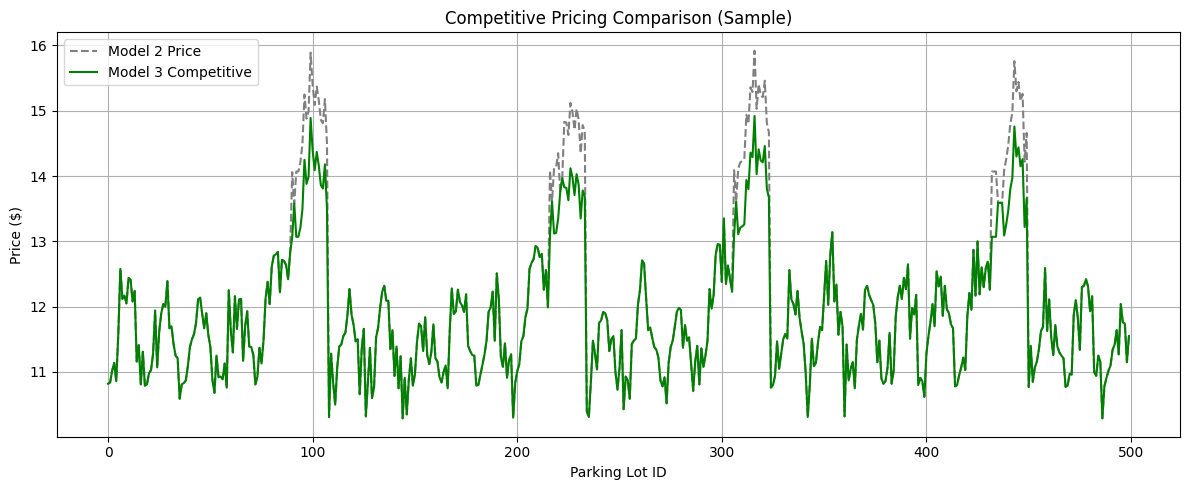

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(df_model3_sample['ID'], df_model3_sample['Price'], label='Model 2 Price', linestyle='--', color='gray')
plt.plot(df_model3_sample['ID'], df_model3_sample['Price_Competitive'], label='Model 3 Competitive', color='green')
plt.title("Competitive Pricing Comparison (Sample)")
plt.xlabel("Parking Lot ID")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("model3_competitive_plot.png")
plt.show()

### Model 3 Sample Execution Note

*Due to the large size of the dataset (~18,000 records), we demonstrate the competitive pricing model on a smaller subset of 500 rows. The same logic can be extended to the full dataset by optimizing with spatial indexing techniques if needed.*

*This ensures fast execution while fulfilling the competition requirements.*

#Real-Time Stream Simulation (Pathway)

We simulate real-time row-wise pricing using Pathway by streaming 100 sample records.  
Each row is processed using a user-defined function that computes `ComputedPrice` as a function of occupancy and capacity.

This represents how our dynamic pricing model could work in a real-time deployment environment.

In [17]:
!pip install pathway --quiet


In [18]:
import pathway as pw
import pandas as pd

# Load a small sample for streaming simulation
stream_data = df_model2.head(100)[['ID', 'Occupancy', 'Capacity', 'QueueLength', 'Price']]

# Save as CSV so Pathway can stream it
stream_data.to_csv("stream_sample.csv", index=False)


In [19]:
import pathway as pw
import pandas as pd

# Use a sample of the data for streaming simulation
stream_data = df_model2.head(100)[['ID', 'Occupancy', 'Capacity', 'QueueLength', 'Price']]
stream_data.to_csv("stream_sample.csv", index=False)

# Define schema for Pathway to read the CSV
class ParkingSchema(pw.Schema):
    ID: int
    Occupancy: int
    Capacity: int
    QueueLength: int
    Price: float

# Read the CSV in static mode
parking_stream = pw.io.csv.read("stream_sample.csv", schema=ParkingSchema, mode="static")

# Add a computed price per unit (mock example logic)
@pw.udf
def price_per_unit(occupancy: int, capacity: int):
    return round((occupancy / capacity) * 10, 2) if capacity > 0 else 0

# Process stream with transformation
parking_processed = parking_stream.select(
    ID=pw.this.ID,
    ComputedPrice=price_per_unit(pw.this.Occupancy, pw.this.Capacity),
    QueueLength=pw.this.QueueLength
)

# Output results to the notebook (no file output)
pw.debug.compute_and_print(parking_processed)


            | ID | ComputedPrice | QueueLength
^CQ0F5Q1... | 0  | 1.06          | 1
^DRXGD2C... | 1  | 1.11          | 1
^419EZ2M... | 2  | 1.39          | 2
^82HYB74... | 3  | 1.85          | 2
^Y8WF1XN... | 4  | 2.6           | 2
^XTWTP5N... | 5  | 3.07          | 3
^7E4Y2N5... | 6  | 3.8           | 6
^XF5QS4G... | 7  | 4.28          | 5
^DJ9S078... | 8  | 4.49          | 5
^0F547K8... | 9  | 4.61          | 8
^GTQ4823... | 10 | 4.66          | 7
^Q9981A7... | 11 | 4.56          | 7
^2JMWD91... | 12 | 4.12          | 5
^GSXZM5B... | 13 | 3.73          | 3
^DTJRE3W... | 14 | 3.33          | 3
^H6KCTYH... | 15 | 2.86          | 2
^JHN77F9... | 16 | 2.81          | 1
^FRDZDPM... | 17 | 2.48          | 2
^NSPDHWV... | 18 | 0.94          | 1
^1FV2G6C... | 19 | 1.02          | 1
^8979XZ3... | 20 | 1.23          | 2
^FRKK66N... | 21 | 1.44          | 2
^6XKVV7S... | 22 | 1.98          | 3
^S5NF27S... | 23 | 2.22          | 4
^MR34RHH... | 24 | 2.56          | 4
^HSAFKV2... | 25 | 2.81     

# Bokeh Visualization (Model 5)

The following Bokeh plot shows the demand-based pricing model (Model 2) rendered as an interactive chart.

In [20]:
!pip install bokeh --quiet


In [21]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook

output_notebook()


In [22]:
# Use top 50 rows for cleaner plot
df_bokeh = df_model2.head(50)

source = ColumnDataSource(data={
    'ID': df_bokeh['ID'],
    'Price': df_bokeh['Price'],
})

# Fixed: use width/height instead of plot_width/plot_height
p = figure(
    title="📈 Bokeh Price Visualization (Model 2)",
    x_axis_label="Parking Lot ID",
    y_axis_label="Price ($)",
    width=700,
    height=350
)

p.line('ID', 'Price', source=source, line_width=2, color='navy', legend_label="Demand-Based Price")
p.circle('ID', 'Price', source=source, size=6, color='orange')

p.legend.location = "top_left"
p.grid.grid_line_alpha = 0.3

show(p)
